In [1]:
from scipy.optimize import curve_fit, minimize
from scipy import integrate
import emcee
import corner
import time
from multiprocessing import cpu_count, Pool
import os
import h5py 
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import astropy.table as aTable
from astropy.cosmology import Planck13
from astropy.cosmology import FlatLambdaCDM
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.distributions as D


mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False


def smf_single_schechter_plot(x, z, a0, a1, a2, a3):
    logM = a0 + a1*z
    alpha1 = a2 + a3*z
    
    term0 = np.exp(-10 ** (x-logM))
    term1 = 10 ** ((alpha1+1)*(x - logM))
    return term0 * term1


def mass_completeness_limit(z):
    f, b, c = [-1.34199453, 13.90578909,  8.53522654]
    return 4*np.pi*f*z**2 + b*z + c




def zmax_mass_completeness_limit(m):
    f, b, c = [-1.34199453, 13.90578909, 8.53522654]

    discriminant = -16*np.pi*f*c + 16*np.pi*f*m + b**2
    sqrt_discriminant = np.sqrt(discriminant)

    z1 = (-b + sqrt_discriminant) / (8 * np.pi * f)
    
    return z1



def integral_limits(z_i, m_i):
    
    zmax_thr = 0.4
    mmax_thr = 13.
    m_lim_i = mass_completeness_limit(z_i)
    zmax_thr_i = zmax_mass_completeness_limit(mass_completeness_limit(zmax_thr))
    
    if m_i > 11.401850153336317:
        return np.array([
            [0.01, z_i],
            [m_lim_i, mmax_thr],
            [z_i, zmax_thr_i],
            [mass_completeness_limit ,mmax_thr]])
    
    z_max_i = zmax_mass_completeness_limit(m_i)
    
    return np.array([
        [0.01, z_i],
        [m_lim_i, mmax_thr],
        [z_i, z_max_i],
        [mass_completeness_limit, mmax_thr]])
    
    
    

def integral_calculation2(a0, a1, a2, a3, m, z):
    limits = integral_limits(z, m)
    result = 0
    result += integrate.dblquad(smf_single_schechter_integral, limits[0][0],
                                limits[0][1], limits[1][0], limits[1][1], args=(a0, a1, a2, a3), 
                                epsabs=1e-3, epsrel=1e-3)[0]
    result += integrate.dblquad(smf_single_schechter_integral, limits[2][0],
                            limits[2][1], limits[3][0] , limits[3][1], args=(a0, a1, a2, a3), 
                                epsabs=1e-3, epsrel=1e-3)[0]
    
    return result



def smf_single_schechter_integral(x, z, a0, a1, a2, a3):
    logM = a0 + a1*z
    alpha1 = a2 + a3*z
    term0 = np.exp(-10 ** (x-logM))
    term1 = 10 ** ((alpha1+1)*(x - logM))
    return term0 * term1



def v_tot_z(f_area, z):
    
    v_min = Planck13.comoving_volume(0.01).value * Planck13.h**3 * f_area
    v_max = Planck13.comoving_volume(z).value * Planck13.h**3 * f_area
    return v_max  - v_min

    
def normalisation(f_area, x, x_median, w_spec, z, z0, best_params):
    a0, a1, a2, a3 = best_params
    
    v_tot = v_tot_z(f_area,z0)
    
    mask_z = (z < z0)
    z_new = z[mask_z]
    x_new = x[mask_z]
    x_median_new = x_median[mask_z]
    w_spec_new = w_spec[mask_z]
    
    weights = []
    
    for i in range(x_median_new.shape[0]):
        weights.append(w_spec_new[i]/integral_calculation2(a0, a1, a2, a3, x_median_new[i], z_new[i]))
        
    return (1/v_tot) *np.sum(weights)


def normalisation_check(f_area, x, x_median, w_spec, z, z0, best_params):
    a0, a1, a2, a3 = best_params
    
    v_tot = v_tot_z(f_area,z0)
    
    mask_z = (z < z0)
    z_new = z[mask_z]
    x_new = x[mask_z]
    x_median_new = x_median[mask_z]
    w_spec_new = w_spec[mask_z]
    
    weights = []
    
    for i in range(x_median_new.shape[0]):
        weights.append(w_spec_new[i]/integral_calculation2(a0, a1, a2, a3, x_median_new[i], z_new[i]))
        
    return v_tot, x_median.shape, x_median_new.shape[0]/x_median.shape[0], np.sum(weights)



def smf_single_schechter_sty(x, z, a0, a1, a2, a3):
    logM = a0 + a1*z
    alpha1 = a2 + a3*z
    
    term0 = np.exp(-10 ** (x-logM[:,None]))
    term1 = 10 ** ((alpha1+1)[:,None]*(x - logM[:,None]))
    return term0 * term1
    


def log_likelihood(a0, a1, a2, a3, interp, x_median, w, z, x):
    q = smf_single_schechter_sty(x, z, a0, a1, a2, a3)
    
    if 9.5 < a0 < 13.5 and \
        2.5 < a1 < 6. and \
       -2.5 < a2 < -0.5  and \
       0. < a3 < 3.:
        a0_v = np.repeat(a0, x_median.shape[0])
        a1_v = np.repeat(a1, x_median.shape[0])
        a2_v = np.repeat(a2, x_median.shape[0])
        a3_v = np.repeat(a3, x_median.shape[0])

        pt = np.array([a0_v, a1_v, a2_v, a3_v, x_median, z]).T
        print(pt)
        I = interp(pt)
        print(I)

        a = np.log10(np.sum(q, axis=1)) - np.log10(I)
        return a * w
    
    return -np.inf

def gathering_data(data, zmax):

    bgs = data
    mask_zlim = (bgs['Z_HP'].data > 0.01) & (bgs['Z_HP'].data < zmax)
    
    z_tot = bgs['Z_HP'].data[mask_zlim]
    x_tot = bgs['provabgs_logMstar'].data[mask_zlim]
    x_median_tot = np.median(x_tot, axis=1)
    w_zfail_tot = bgs['provabgs_w_zfail'].data[mask_zlim]
    w_fib_tot = bgs['provabgs_w_fibassign'].data[mask_zlim]
    vmax_tot = bgs['Vmax'].data[mask_zlim]
    
    
    mass_comp_lim = mass_completeness_limit(z_tot)
    # mask_mlim = []
    # for i in range(len(x_median_tot)):
    #     mask_mlim.append(x_median_tot[i] > mass_comp_lim[i])
    mask_mlim = x_median_tot > mass_completeness_limit(z_tot)
        
    
    mask = (w_zfail_tot > 0) & (mask_mlim)
    
    z = z_tot[mask].astype(np.float32)
    x = x_tot[mask].astype(np.float32)
    x_median = x_median_tot[mask].astype(np.float32)
    w_zfail = w_zfail_tot[mask].astype(np.float32)
    w_fib = w_fib_tot[mask].astype(np.float32)
    vmax = vmax_tot[mask].astype(np.float32)
    
    
    f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
    v_zmin = Planck13.comoving_volume(0.01).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(0.09).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_sub = v_zmax - v_zmin
    
    
    # w_spec * 1/Vmax
    w = (w_zfail*w_fib) * v_sub / (vmax.clip(v_zmin, v_zmax) - v_zmin)
    n = np.sum(w)/v_sub
    
    # Spectroscopic weights
    w_spec = (w_zfail*w_fib)

    return z, x, x_median, w_spec

In [2]:
cosmo = FlatLambdaCDM(H0=67.8, Om0=0.307)

# Read hdf5 for BGS data
bgs = aTable.Table.read('../data/BGS_ANY_full.provabgs.lite.hdf5')
is_bgs_bright = bgs['is_bgs_bright']
is_bgs_faint = bgs['is_bgs_faint']

bgs = bgs[bgs['is_bgs_bright']]

# Gathering data
# Exluding galaxies for z < 0.01 and z > 0.4 because I don't have the mass completeness limit for those

mask_zlim = (bgs['Z_HP'].data > 0.01) & (bgs['Z_HP'].data < 0.4)


z_tot = bgs['Z_HP'].data[mask_zlim]
x_tot = bgs['provabgs_logMstar'].data[mask_zlim]
x_median_tot = np.median(x_tot, axis=1)
w_zfail_tot = bgs['provabgs_w_zfail'].data[mask_zlim]
w_fib_tot = bgs['provabgs_w_fibassign'].data[mask_zlim]
vmax_tot = bgs['Vmax'].data[mask_zlim]


mass_comp_lim = mass_completeness_limit(z_tot)
mask_mlim = []
for i in range(len(x_median_tot)):
    mask_mlim.append(x_median_tot[i] > mass_comp_lim[i])
    

mask = (w_zfail_tot > 0) & (mask_mlim)

z = z_tot[mask].astype(np.float32)
x = x_tot[mask].astype(np.float32)
x_median = x_median_tot[mask].astype(np.float32)
w_zfail = w_zfail_tot[mask].astype(np.float32)
w_fib = w_fib_tot[mask].astype(np.float32)
vmax = vmax_tot[mask].astype(np.float32)


f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
v_zmin = Planck13.comoving_volume(0.01).value * Planck13.h**3 * f_area # (Mpc/h)^3
v_zmax = Planck13.comoving_volume(0.09).value * Planck13.h**3 * f_area # (Mpc/h)^3
v_sub = v_zmax - v_zmin


# w_spec * 1/Vmax
w = (w_zfail*w_fib) * v_sub / (vmax.clip(v_zmin, v_zmax) - v_zmin)
n = np.sum(w)/v_sub

# Spectroscopic weights
w_spec = (w_zfail*w_fib)

In [3]:
z03, x03, x_median03, w_spec03 = gathering_data(bgs, 0.3)
z02, x02, x_median02, w_spec02 = gathering_data(bgs, 0.2)
z005, x005, x_median005, w_spec005 = gathering_data(bgs, 0.05)

(6.0, 13.2)

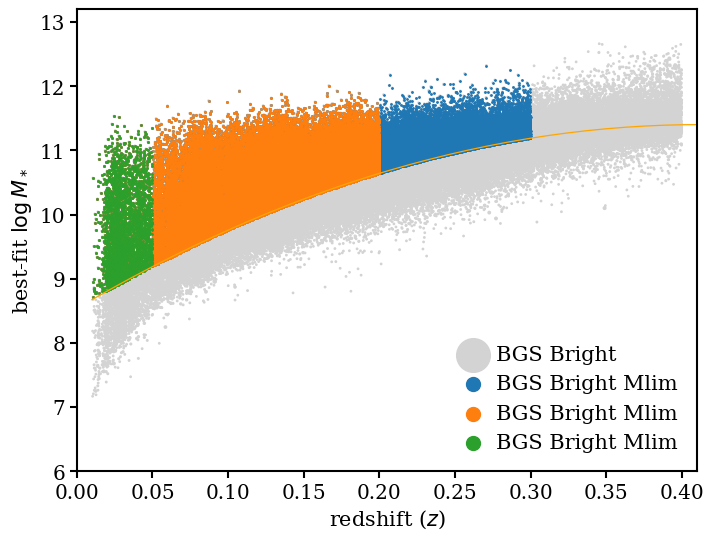

In [4]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

sub.scatter(z_tot, x_median_tot, 
            s=w_zfail_tot * w_fib_tot, c='lightgrey', label='BGS Bright')

sub.scatter(z03, x_median03, 
            s=1, c='C0', label='BGS Bright Mlim')


sub.scatter(z02, x_median02, 
            s=1, c='C1', label='BGS Bright Mlim')

sub.scatter(z005, x_median005, 
            s=1, c='C2', label='BGS Bright Mlim')



sub.plot(np.linspace(0.01, 0.65), mass_completeness_limit(np.linspace(0.01, 0.65)),
         color = 'orange', linewidth=0.9)


# sub.scatter(pt[problems[0]][:,5], pt[problems[0]][:,4], c='red', s=1)


sub.legend(loc='lower right', fontsize=15, markerscale=10, handletextpad=0.1)
sub.set_xlabel(r"redshift ($z$)", fontsize=15)
sub.set_xlim(0., 0.41)
sub.set_ylabel(r"best-fit $\log M_*$", fontsize=15)
sub.set_ylim(6., 13.2)

In [5]:
# a0, a1, a2, a3 = [1.01315955e+01,  5.07865920e+00, -1.76294714e+00,  4.57523001e-03]
a0, a1, a2, a3 = 10., 3.2, -1.5, 1.5

nn = 20
a0_lin = np.linspace(9.5, 13.5, nn)
a1_lin = np.linspace(2.5, 6., nn)
a2_lin = np.linspace(-2.5, -0.5, nn)
a3_lin = np.linspace(0, 3., nn)
m_lin = np.linspace(x_median.min(), x_median.max(), nn)
z_lin = np.linspace(z.min(), z.max(), nn)

grid_data = np.load('../grids/conc_grid_6d_20sample.npy')
interp = RegularGridInterpolator((a0_lin, a1_lin, a2_lin, a3_lin, m_lin, z_lin), grid_data)

In [6]:
q = smf_single_schechter_sty(x005, z005, a0, a1, a2, a3)

np.log10(np.sum(q, axis=1))

a0_v = np.repeat(a0, x_median005.shape[0])
a1_v = np.repeat(a1, x_median005.shape[0])
a2_v = np.repeat(a2, x_median005.shape[0])
a3_v = np.repeat(a3, x_median005.shape[0])

pt = np.array([a0_v, a1_v, a2_v, a3_v, x_median005, z005]).T

problems = np.where(np.isnan(np.log10(interp(pt))))

In [7]:
problems

(array([], dtype=int64),)

In [8]:
log_likelihood(a0, a1, a2, a3, interp, x_median005, w_spec005, z005, x005)

[[10.          3.2        -1.5         1.5         9.46084213  0.03138858]
 [10.          3.2        -1.5         1.5         9.92421341  0.04546919]
 [10.          3.2        -1.5         1.5        10.62957954  0.04552807]
 ...
 [10.          3.2        -1.5         1.5         9.24262619  0.02763683]
 [10.          3.2        -1.5         1.5         9.16594028  0.04495921]
 [10.          3.2        -1.5         1.5         9.51198769  0.03755268]]
[0.08982409 0.10100082 0.11782104 ... 0.07309535 0.04949809 0.0873824 ]


array([3.238478  , 2.84231159, 1.53016056, ..., 3.47372389, 7.00071398,
       3.27706434])

In [ ]:
z_err = pt[problems[0]][:,4]
x_err = pt[problems[0]][:,5]

In [ ]:
integral_limits(z_err[0], x_err[0])

In [ ]:
z_err[0], x_err[0]

----
----

In [ ]:
z_err = pt[problems[0]][:,4]
x_err = pt[problems[0]][:,5]

In [ ]:
integral_limits(z_err[0], x_err[0])

In [ ]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

sub.scatter(z_tot, x_median_tot, 
            s=w_zfail_tot * w_fib_tot, c='lightgrey', label='BGS Bright')

sub.scatter(z, x_median, 
            s=w_zfail * w_fib, c='C0', label='BGS Bright Mlim')

# sub.scatter(z0, x0, s=5, color='orange')
# sub.scatter(z_test[:20], x_test[:20], color='black')

# sub.scatter(z0, mass_completeness_limit(z0), color='red')
# sub.scatter(zmax_mass_completeness_limit(x0), x0, color='red')

# sub.plot(rl[:,0], rl[:,1],
#             color='red')

# sub.scatter(zlim_[:36], mlim_, 
#             s=2, color='red')

sub.plot(np.linspace(0.01, 0.65), mass_completeness_limit(np.linspace(0.01, 0.65)),
         color = 'orange')


sub.scatter(pt[problems[0]][:,5], pt[problems[0]][:,4], c='red', s=1)

# sub.scatter(zlim_[:36], mlim_, color='black')

# sub.scatter(xv, yv, color='red')

sub.legend(loc='lower right', fontsize=15, markerscale=10, handletextpad=0.1)
sub.set_xlabel(r"redshift ($z$)", fontsize=15)
sub.set_xlim(0., 0.41)
sub.set_ylabel(r"best-fit $\log M_*$", fontsize=15)
sub.set_ylim(6., 13.2)

In [ ]:
problems

In [ ]:
pt[problems[0][0]][-1]

----
----

In [ ]:
plt.hist(x_median, bins=100)

In [ ]:
hist, bin_edges = np.histogram(x_median, bins=100)
cumulative_hist = np.cumsum(hist)
plt.plot(bin_edges[1:], cumulative_hist)
plt.plot(np.repeat(11.,100), np.linspace(0,80000, 100))

In [ ]:
x.shape

In [ ]:
log_likelihood(a0, a1, a2, a3, interp, x_median, w_spec, z, x)

In [ ]:
print(pt)

In [ ]:
pt[0]

In [ ]:
problems

In [ ]:
for indx in problems[0]:
    print(interp(pt[indx]), pt[indx])

------
------

In [ ]:
# filename = "redshift_fit_1Schechter_2_50w_600s_v4.h5"
# filename = "redshift_fit_1Schechter_2_50w_600s_v4_newgrid.h5"
filename = "../emcee_runs/redshift_fit_1Schechter_50w_600s_v4_newgrid_NT_04z.h5"
reader = emcee.backends.HDFBackend(filename)
samples = reader.get_chain()

ndim = 4
labels = [r'$a_{0}$', r'$a_{1}$', r'$a_{2}$', r'$a_{3}$']


fig, axes = plt.subplots(ndim, figsize=(10, 10), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")

# plt.show()
plt.subplots_adjust(bottom=0.2)

In [ ]:
flat_samples = reader.get_chain(discard=200, thin=15, flat=True) 
fig = corner.corner(flat_samples, labels=labels, quantiles=(0.16, 0.50, 0.84), show_titles=True);
plt.show()

In [ ]:
mcmc = np.array([np.percentile(flat_samples[:, i], [16, 50, 84]) for i in range(flat_samples.shape[1])])
a0_mcmc, a1_mcmc, a2_mcmc, a3_mcmc = mcmc[:,1]

In [ ]:
mcmc[:,1]

In [ ]:
x0 = np.linspace(8,13,100)
z0 = np.linspace(0.01, 0.2, 5)
# z0 = np.linspace(0.2, 0.4, 5)

plt.figure(figsize=(8,8))

for z0_i in z0:
    z_label = "{:.{}f}".format(z0_i,2)
    plt.plot(x0, smf_single_schechter_plot(x0, z0_i, a0_mcmc, a1_mcmc, a2_mcmc, a3_mcmc), label=f'{z_label}')

plt.yscale('log')
plt.legend(loc='best')
plt.xlabel(r'$\log(M_{*})$', fontsize=15)
plt.ylabel(r'$\log(\phi(M_{*}))$', fontsize=15)
plt.ylim(5e-9, 4e3)
plt.xlim(8,13)

In [ ]:
# norm = normalisation(f_area, x, x_median, w_spec, z, z0[-1], mcmc[:,1])

In [ ]:
z0=0.035
plt.figure(figsize=(8,8))


z_label = "{:.{}f}".format(z0_i,2)
plt.plot(x0, 0.021697444966845558*smf_single_schechter_plot(x0, z0, a0_mcmc, a1_mcmc, a2_mcmc, a3_mcmc), label=f'{z_label}')

plt.yscale('log')
plt.legend(loc='best')
plt.xlabel(r'$\log(M_{*})$', fontsize=15)
plt.ylabel(r'$\log(\phi(M_{*}))$', fontsize=15)
plt.ylim(5e-6, 4e0)
plt.xlim(8,13)

In [ ]:
class GaussianMixtureModel(nn.Module):
    def __init__(self, n_components: int=2, mmin=7., mmax=13.):
        super().__init__()
        logweights = torch.zeros(n_components, )
        means   = (mmax-mmin)*torch.rand(n_components, ) + mmin
        logstdevs  = 0.1*torch.tensor(np.random.uniform(size=n_components)) - 1.
        
        self.logweights = torch.nn.Parameter(logweights)
        self.means   = torch.nn.Parameter(means)
        self.logstdevs  = torch.nn.Parameter(logstdevs)
    
    def forward(self, x):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return - gmm.log_prob(x).mean()
    
    def log_prob(self, x): 
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return gmm.log_prob(x)
    
    def sample(self, N):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        
        return gmm.sample(N)

In [ ]:
if torch.cuda.is_available():
    device = torch.device(type='cuda', index=0)
else:
    device = 'cpu'

In [ ]:
dat_dir = '/home/fede'

mlim = [8.975, 9.325, 9.5, 9.85, 10.024999999999999, 10.2, 10.375, 10.55, 10.725, 10.725, 10.899999999999999, 
        10.899999999999999, 11.075, 11.075, 11.425, 11.425]

zmins, zmaxs = [0.01], [0.05]

fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for i, zmin, zmax in zip(range(4), zmins, zmaxs):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

    # calculate normalization
    norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)
    #psmf_model = best_models_z[i] 
    psmf_model = torch.load(os.path.join(dat_dir, 'psmf.gmm.bgs_bright.z%.2f_%.2f.last.pt' % (zmin, zmax)), map_location=device)
    with torch.no_grad(): 
        post_prime = psmf_model.sample((100000,))
    
    # calculate normalization    
    #_ = sub.hist(np.median(logM_posteriors[zlim], axis=1), 
    #             weights=w_import[zlim]*norm, #10000./np.sum(w_import[zlim]), 
    #             range=(6., 13.), bins=40, histtype='step', 
    #             color='k', linestyle='--', linewidth=1) 
    h, be = np.histogram(np.array(post_prime.detach().cpu()), 
                 weights=np.repeat(norm, 100000) / 100000, range=(6., 13.), bins=40)
    
    sub.step(be[:-1], h, where='pre', color='C%i' % i, linestyle='--')
    sub.step(be[:-1][be[:-1] > mlim[2*i+1]], h[be[:-1] > mlim[2*i+1]], where='pre', color='C%i' % i, linestyle='-')
    sub.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))

    sub.plot(x0, 0.021697444966845558*smf_single_schechter_plot(x0, z0, a0_mcmc, a1_mcmc, a2_mcmc, a3_mcmc)
             , label='emcee', color='green')
#     sub.plot(x0, 0.021697444966845558*smf_single_schechter_plot(x0, z0, 10.5, a1_mcmc, -1., a3_mcmc), color='red')
    sub.plot(x0, 0.021697444966845558*smf_single_schechter_plot(x0, z0, 10.3, a1_mcmc, -1.2, a3_mcmc), 
            label='manual', linestyle='dashed', color='orange')
    
    
    #sub.axvline(mlim[2*i+1], color='C%i' % i, linestyle=':')
sub.legend(loc='lower left', fontsize=15)
sub.set_xlabel(r'$\log M_*$', fontsize=15)
sub.set_xlim(7., 12.5)
sub.set_ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=15)
sub.set_yscale('log')
sub.set_ylim(5e-9, 4e0)
plt.show()

In [ ]:
a0_mcmc, a1_mcmc, a2_mcmc, a3_mcmc

### Use [10.3, 5.07, -1.2, 0.02] as starting point for a new emcee

In [ ]:
np.save('/home/fede/nersc_test/fig.npy', fig)

In [ ]:
# np.linspace(0.1,0.4, 10)

# ngal

# np.diff(ngal)

# np.diff(ngal)/ ngal[:-1]

# list(zip(np.linspace(0.1,0.4, 10), np.diff(ngal)/ ngal[:-1]))

# ngal[:-1]

# 26294-14824, 39033 - 26294